In [1]:
!pip install keras-tuner scikit-learn --upgrade transformers imbalanced-learn
import gzip
import pandas as pd
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from transformers import DistilBertTokenizer, TFDistilBertModel
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import keras_tuner as kt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 68.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.2
    Uninstalling transformers-4.50.2:
      Successfully uninstalled transformers-4.50.2


In [2]:
jsonl_gz_path = "/content/Magazine_Subscriptions.jsonl.gz"

def load_jsonl_gz(file_path):
    data = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Load dataset and rename columns
df = load_jsonl_gz(jsonl_gz_path)
df.rename(columns={"your_text_column": "text", "your_rating_column": "rating"}, inplace=True)

# Convert ratings to 0-4 scale
df["label"] = df["rating"] - 1

In [3]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [4]:
def get_bert_embeddings(texts, batch_size=1000):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), padding=True, truncation=True, max_length=64, return_tensors="tf")
        outputs = bert_model(inputs["input_ids"], attention_mask=inputs["attention_mask"])
        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Using [CLS] token embeddings
        embeddings.append(batch_embeddings)
        print(f"✅ Processed {i + len(batch_texts)} samples")
    return np.vstack(embeddings)

# Convert text into BERT embeddings
X = get_bert_embeddings(df["text"], batch_size=1000)
y = df["label"].values

✅ Processed 1000 samples
✅ Processed 2000 samples
✅ Processed 3000 samples
✅ Processed 4000 samples
✅ Processed 5000 samples
✅ Processed 6000 samples
✅ Processed 7000 samples
✅ Processed 8000 samples
✅ Processed 9000 samples
✅ Processed 10000 samples
✅ Processed 11000 samples
✅ Processed 12000 samples
✅ Processed 13000 samples
✅ Processed 14000 samples
✅ Processed 15000 samples
✅ Processed 16000 samples
✅ Processed 17000 samples
✅ Processed 18000 samples
✅ Processed 19000 samples
✅ Processed 20000 samples
✅ Processed 21000 samples
✅ Processed 22000 samples
✅ Processed 23000 samples
✅ Processed 24000 samples
✅ Processed 25000 samples
✅ Processed 26000 samples
✅ Processed 27000 samples
✅ Processed 28000 samples
✅ Processed 29000 samples
✅ Processed 30000 samples
✅ Processed 31000 samples
✅ Processed 32000 samples
✅ Processed 33000 samples
✅ Processed 34000 samples
✅ Processed 35000 samples
✅ Processed 36000 samples
✅ Processed 37000 samples
✅ Processed 38000 samples
✅ Processed 39000 sam

In [5]:
smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=20, stratify=y)

In [7]:
def build_ffnn_model(hp):
    model = Sequential()

    # First hidden layer
    model.add(Dense(hp.Int('units_1', 256, 512, step=128), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.3, 0.5, step=0.1)))

    # Second hidden layer
    model.add(Dense(hp.Int('units_2', 128, 256, step=64), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', 0.3, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(5, activation='softmax'))  # 5 sentiment classes

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0001, 5e-5])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [8]:
# Initialize tuner
tuner = kt.RandomSearch(
    build_ffnn_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_tuner',
    project_name='ffnn_tuning'
)

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Search for best hyperparameters
tuner.search(
    X_train, y_train,
    epochs=30,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Display hyperparameter search summary
tuner.search_space_summary()

Trial 10 Complete [00h 02m 14s]
val_accuracy: 0.6364639401435852

Best val_accuracy So Far: 0.7566542625427246
Total elapsed time: 00h 22m 11s
Search space summary
Default search space size: 5
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 5e-05], 'ordered': True}
Best Hyperparameters: {'units_1': 512, 'dropout_1': 0.4, 'units_2': 256, 'dropout_2': 0.4, 'learning_rate': 5e-05}


In [ ]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

2441/2441 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
✅ Tuned FFNN Test Accuracy: 0.7547800473842607


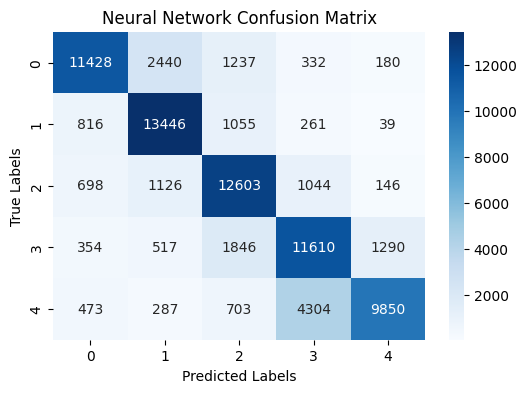

F1-Score: 0.7542


In [9]:
best_models = tuner.get_best_models(num_models=1)
best_model = best_models[0]

# Predict on test set
y_pred_ffnn = np.argmax(best_model.predict(X_test), axis=1)

# Accuracy score
print("✅ Tuned FFNN Test Accuracy:", accuracy_score(y_test, y_pred_ffnn))

# Confusion Matrix
cm_ffnn = confusion_matrix(y_test, y_pred_ffnn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ffnn, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# F1-score
f1 = f1_score(y_test, y_pred_ffnn, average='weighted')
print(f"F1-Score: {f1:.4f}")

In [10]:
# Save the best model
best_model.save("Best_sentiment_model.h5")